# Sales Analysis

### Import necessary libraries

In [109]:
import os
import pandas as pd
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

### Merge data from each month into one dataframe

In [110]:
path = r"C:\Users\Paramita_Saha\OneDrive - Dell Technologies\Documents\Data Science\Projects\Dataset"
files = [file for file in os.listdir(path) if not file.startswith('.')] # Ignore hidden files

all_months_data = pd.DataFrame()

for file in files:
    current_data = pd.read_csv(path+"/"+file)
    all_months_data = pd.concat([all_months_data, current_data])
    
all_months_data.to_csv("all_data_copy.csv", index=False)
    

#### Read in updated dataframe

In [111]:
all_data = all_months_data
all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
1,NaN,NaN,NaN,NaN,NaN,NaN
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"


### Data Validation and Numeric Exploration

In [112]:
all_data.shape

(186850, 6)

In [113]:
all_data.dtypes

Order ID            object
Product             object
Quantity Ordered    object
Price Each          object
Order Date          object
Purchase Address    object
dtype: object

 **I have to convert data types for price, Quantity to numeric values and Order date to date or datetime. It will be done later on in this report** 

In [114]:
all_data.isna().sum()

Order ID            545
Product             545
Quantity Ordered    545
Price Each          545
Order Date          545
Purchase Address    545
dtype: int64

In [115]:
all_data.describe()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
count,186305,186305,186305,186305,186305,186305
unique,178438,20,10,24,142396,140788
top,Order ID,USB-C Charging Cable,1,11.95,Order Date,Purchase Address
freq,355,21903,168552,21903,355,355


### Clean up the data!
The first step in this is figuring out what we need to clean. I have found in practice, that you find things you need to clean as you perform operations and get errors. Based on the error, you decide how you should go about cleaning the data

#### Drop rows of NAN

In [116]:
# Find NAN
nan_df = all_data[all_data.isna().any(axis=1)]
print(nan_df.head())

all_data = all_data.dropna(how='all')
all_data.head()

     Order ID Product Quantity Ordered Price Each Order Date Purchase Address
1         NaN     NaN              NaN        NaN        NaN              NaN
356       NaN     NaN              NaN        NaN        NaN              NaN
735       NaN     NaN              NaN        NaN        NaN              NaN
1433      NaN     NaN              NaN        NaN        NaN              NaN
1553      NaN     NaN              NaN        NaN        NaN              NaN


,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001"
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215"
3,176560,Google Phone,1,600,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001"
5,176561,Wired Headphones,1,11.99,04/30/19 09:27,"333 8th St, Los Angeles, CA 90001"


#### Get rid of text in order date column

In [117]:
all_data = all_data[all_data['Order Date'].str[0:2]!='Or']

#### Make columns correct type

In [118]:
all_data['Quantity Ordered'] = pd.to_numeric(all_data['Quantity Ordered'])
all_data['Price Each'] = pd.to_numeric(all_data['Price Each'])

### Augment data with additional columns

#### Add month column

In [119]:
all_data['Month'] = pd.to_datetime(all_data['Order Date'], format='%m/%d/%y %H:%M').dt.month
all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001",4
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215",4
3,176560,Google Phone,1,600.00,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001",4
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001",4
5,176561,Wired Headphones,1,11.99,04/30/19 09:27,"333 8th St, Los Angeles, CA 90001",4


#### Add city column

In [120]:
def get_city(address):
    return address.split(",")[1].strip(" ")

def get_state(address):
    return address.split(",")[2].split(" ")[1]

all_data['City'] = all_data['Purchase Address'].apply(lambda x: f"{get_city(x)}  ({get_state(x)})")
all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,City
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001",4,Dallas (TX)
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215",4,Boston (MA)
3,176560,Google Phone,1,600.00,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001",4,Los Angeles (CA)
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001",4,Los Angeles (CA)
5,176561,Wired Headphones,1,11.99,04/30/19 09:27,"333 8th St, Los Angeles, CA 90001",4,Los Angeles (CA)


## Data Exploration!

#### Question 1: What was the best month for sales? How much was earned that month? 

In [121]:
all_data['Sales'] = all_data['Quantity Ordered'].astype('int') * all_data['Price Each'].astype('float')

In [122]:
month_group=all_data.groupby(['Month']).sum()
month_group

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,City,Sales
Month,,,,,,,,
1,2971502978172978172979692983442990492991253003...,Lightning Charging CableiPhoneLightning Chargi...,10903,1811768.38,01/01/20 00:3801/01/20 00:2201/01/20 00:2201/0...,"427 Wilson St, Dallas, TX 75001519 13th St, Ne...",Dallas (TX)New York City (NY)New York City ...,1822256.73
2,1505021505031505041505051505061505071505081505...,iPhoneAA Batteries (4-pack)27in 4K Gaming Moni...,13449,2188884.72,02/18/19 01:3502/13/19 07:2402/18/19 09:4602/0...,"866 Spruce St, Portland, ME 0410118 13th St, S...",Portland (ME)San Francisco (CA)New York City...,2202022.42
3,1505331505411508121517491520361532841535441538...,AAA Batteries (4-pack)AAA Batteries (4-pack)Wi...,17005,2791207.83,03/01/19 03:0603/01/19 01:0303/01/19 02:1803/0...,"270 Dogwood St, San Francisco, CA 94016683 Ada...",San Francisco (CA)Portland (OR)San Francisco...,2807100.38
4,1765581765591765601765601765611765621765631765...,USB-C Charging CableBose SoundSport Headphones...,20558,3367671.02,04/19/19 08:4604/07/19 22:3004/12/19 14:3804/1...,"917 1st St, Dallas, TX 75001682 Chestnut St, B...",Dallas (TX)Boston (MA)Los Angeles (CA)Los A...,3390670.24
5,1769781775511777781777781790761790761791341800...,Apple Airpods Headphones27in FHD MonitoriPhone...,18667,3135125.13,05/01/19 03:2905/01/19 00:1305/01/19 00:4805/0...,"589 Lake St, Portland, OR 97035615 Lincoln St,...",Portland (OR)San Francisco (CA)Boston (MA)B...,3152606.75
6,2099212099222099232099242099252099262099272099...,USB-C Charging CableMacbook Pro LaptopThinkPad...,15253,2562025.61,06/23/19 19:3406/30/19 10:0506/24/19 20:1806/0...,"950 Walnut St, Portland, ME 0410180 4th St, Sa...",Portland (ME)San Francisco (CA)Los Angeles ...,2577802.26
7,2229102229112229122229132229142229152229162229...,Apple Airpods HeadphonesFlatscreen TVAA Batter...,16072,2632539.56,07/26/19 16:5107/05/19 08:5507/29/19 12:4107/2...,"389 South St, Atlanta, GA 30301590 4th St, Sea...",Atlanta (GA)Seattle (WA)Atlanta (GA)Atlanta...,2647775.76
8,2366702366712366722366732366742366752366762366...,Wired HeadphonesBose SoundSport HeadphonesiPho...,13448,2230345.42,08/31/19 22:2108/15/19 15:1108/06/19 14:4008/2...,"359 Spruce St, Seattle, WA 98101492 Ridge St, ...",Seattle (WA)Dallas (TX)Portland (OR)Los Ang...,2244467.88
9,2388342392852406362410542423432428652436672449...,Apple Airpods Headphones34in Ultrawide Monitor...,13109,2084992.09,09/01/19 04:1309/01/19 01:0909/01/19 02:0709/0...,"761 Forest St, San Francisco, CA 94016373 1st ...",San Francisco (CA)San Francisco (CA)Seattle ...,2097560.13


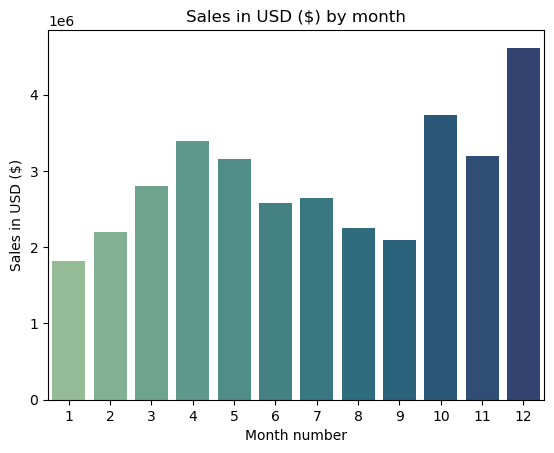

In [123]:
g=sns.barplot(data=month_group,x=month_group.index,y='Sales',palette='crest')
g.set_title("Sales in USD ($) by month")
plt.ylabel('Sales in USD ($)')
plt.xlabel('Month number')
plt.show()

#### Question 2: What city sold the most product?

In [124]:
group_city = all_data.groupby(['City']).sum()
group_city

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,Sales
City,,,,,,,,
Atlanta (GA),1765641765711765821765891766231766271766341766...,USB-C Charging CableLightning Charging CableBo...,16602,2779908.20,04/12/19 10:5804/19/19 14:2904/27/19 12:2004/0...,"790 Ridge St, Atlanta, GA 30301253 Johnson St,...",104794,2795498.58
Austin (TX),1765911766091766741766771766861767011767051767...,Apple Airpods HeadphonesApple Airpods Headphon...,11153,1809873.61,04/21/19 07:2104/11/19 16:5904/20/19 20:5304/0...,"600 Maple St, Austin, TX 73301267 11th St, Aus...",69829,1819581.75
Boston (MA),1765591765661765781765811765851765851766001766...,Bose SoundSport HeadphonesWired HeadphonesAppl...,22528,3637409.77,04/07/19 22:3004/08/19 14:0504/09/19 23:3504/0...,"682 Chestnut St, Boston, MA 0221583 7th St, Bo...",141112,3661642.01
Dallas (TX),1765581765691765701765771765961766021766101766...,USB-C Charging Cable27in 4K Gaming MonitorAA B...,16730,2752627.82,04/19/19 08:4604/16/19 19:2304/22/19 15:0904/0...,"917 1st St, Dallas, TX 75001657 Hill St, Dalla...",104620,2767975.40
Los Angeles (CA),1765601765601765611765671765741765741765761765...,Google PhoneWired HeadphonesWired HeadphonesGo...,33289,5421435.23,04/12/19 14:3804/12/19 14:3804/30/19 09:2704/1...,"669 Spruce St, Los Angeles, CA 90001669 Spruce...",208325,5452570.80
New York City (NY),1765721765751765791765901765991766131766371766...,Apple Airpods HeadphonesAAA Batteries (4-pack)...,27932,4635370.83,04/04/19 20:3004/27/19 00:3004/11/19 10:2304/1...,"149 Dogwood St, New York City, NY 10001433 Hil...",175741,4664317.43
Portland (ME),1767731768791769091770721772301772331772991773...,AAA Batteries (4-pack)Flatscreen TVWired Headp...,2750,447189.25,04/25/19 20:0704/13/19 14:1504/22/19 09:5304/0...,"30 9th St, Portland, ME 04101370 Sunset St, Po...",17144,449758.27
Portland (OR),1765831765931766171766421766461766481766621767...,AAA Batteries (4-pack)Lightning Charging Cable...,11303,1860558.22,04/20/19 12:0004/15/19 13:4504/25/19 08:0304/1...,"146 Jackson St, Portland, OR 97035906 7th St, ...",70621,1870732.34
San Francisco (CA),1765621765651765731765841765861765861765941765...,USB-C Charging CableMacbook Pro LaptopUSB-C Ch...,50239,8211461.74,04/29/19 13:0304/24/19 10:3804/27/19 18:4104/2...,"381 Wilson St, San Francisco, CA 94016915 Will...",315520,8262203.91


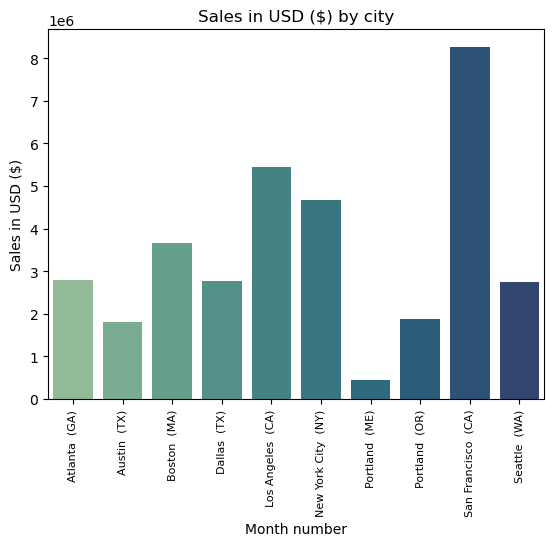

In [125]:
g=sns.barplot(data=group_city,x=group_city.index,y='Sales',palette='crest')
g.set_title("Sales in USD ($) by city")
plt.ylabel('Sales in USD ($)')
plt.xlabel('Month number')
plt.xticks(rotation='vertical', size=8)
plt.show()

#### Question 3: What time should we display advertisements to maximize likelihood of customer's buying product?

In [126]:
# Add hour column
all_data['Hour'] = pd.to_datetime(all_data['Order Date'], format='%m/%d/%y %H:%M').dt.hour
all_data['Minute'] = pd.to_datetime(all_data['Order Date'], format='%m/%d/%y %H:%M').dt.minute
all_data['Count'] = 1
all_data.head()

,Order ID,Product,Quantity Ordered,Price Each,Order Date,Purchase Address,Month,City,Sales,Hour,Minute,Count
0,176558,USB-C Charging Cable,2,11.95,04/19/19 08:46,"917 1st St, Dallas, TX 75001",4,Dallas (TX),23.90,8,46,1
2,176559,Bose SoundSport Headphones,1,99.99,04/07/19 22:30,"682 Chestnut St, Boston, MA 02215",4,Boston (MA),99.99,22,30,1
3,176560,Google Phone,1,600.00,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001",4,Los Angeles (CA),600.00,14,38,1
4,176560,Wired Headphones,1,11.99,04/12/19 14:38,"669 Spruce St, Los Angeles, CA 90001",4,Los Angeles (CA),11.99,14,38,1
5,176561,Wired Headphones,1,11.99,04/30/19 09:27,"333 8th St, Los Angeles, CA 90001",4,Los Angeles (CA),11.99,9,27,1


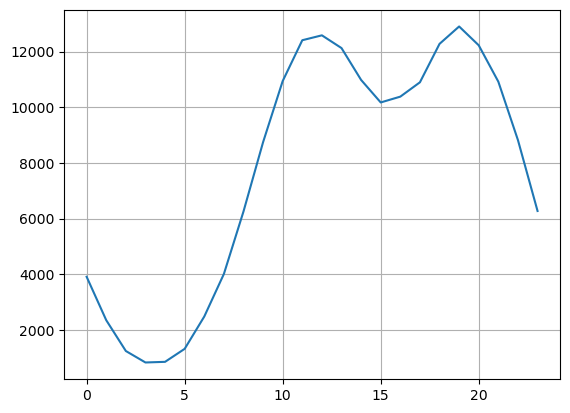

In [127]:
keys = [pair for pair, df in all_data.groupby(['Hour'])]

plt.plot(keys, all_data.groupby(['Hour']).count()['Count'])
plt.grid()
plt.show()

#### Question 4) What product sold the most? Why do you think it sold the most?

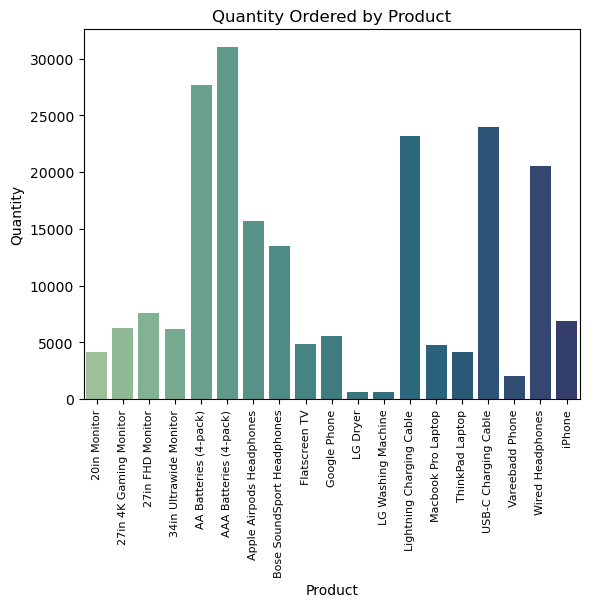

In [128]:
product_group = all_data.groupby('Product')
quantity_ordered = product_group.sum()[['Quantity Ordered']]

g=sns.barplot(data=quantity_ordered,x=quantity_ordered.index,y='Quantity Ordered',palette='crest')
g.set_title("Quantity Ordered by Product")
plt.ylabel('Quantity')
plt.xlabel('Product')
plt.xticks(rotation='vertical', size=8)
plt.show()

### Market Basket Analysis

#### Use Cases
* Build Recommendation engine
* Improve product recommendations on an e-commerce store
* Cross-sell products in a retail setting
* Improve inventory management
* Upsell products

#### What two products sold best together?

In [129]:
df = all_data[all_data['Order ID'].duplicated(keep=False)].copy()

df['Grouped'] = df.groupby('Order ID')['Product'].transform(lambda x: ','.join(x))
df2 = df[['Order ID', 'Grouped']].drop_duplicates()

In [130]:
df2.head()

,Order ID,Grouped
3,176560,"Google Phone,Wired Headphones"
18,176574,"Google Phone,USB-C Charging Cable"
30,176585,"Bose SoundSport Headphones,Bose SoundSport Hea..."
32,176586,"AAA Batteries (4-pack),Google Phone"
119,176672,"Lightning Charging Cable,USB-C Charging Cable"


In [131]:
from itertools import combinations
from collections import Counter

count = Counter()

for row in df2['Grouped']:
    row_list = row.split(',')
    count.update(Counter(combinations(row_list, 2)))

for key,value in count.most_common(10):
    print(key, value)

('iPhone', 'Lightning Charging Cable') 1005
('Google Phone', 'USB-C Charging Cable') 987
('iPhone', 'Wired Headphones') 447
('Google Phone', 'Wired Headphones') 414
('Vareebadd Phone', 'USB-C Charging Cable') 361
('iPhone', 'Apple Airpods Headphones') 360
('Google Phone', 'Bose SoundSport Headphones') 220
('USB-C Charging Cable', 'Wired Headphones') 160
('Vareebadd Phone', 'Wired Headphones') 143
('Lightning Charging Cable', 'Wired Headphones') 92


This list would help in order to offer the "partner product" when someone buy the other product of the pair

#### Quantity of products by Order ID

Product
1    171301
2      6778
3       340
4        17
5         1
Name: count, dtype: int64

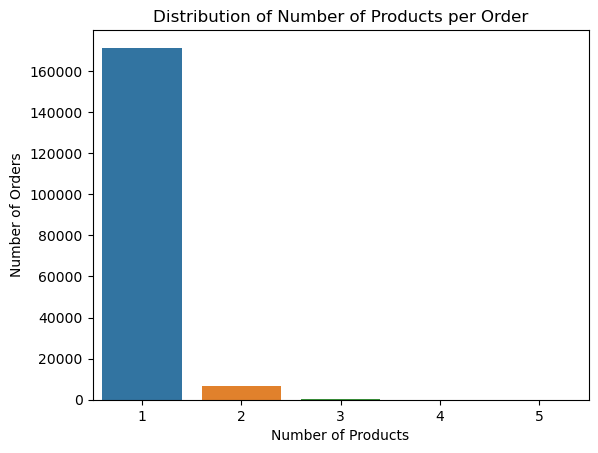

In [132]:
product_counts = all_data.groupby('Order ID')['Product'].count().value_counts()
display(product_counts)
sns.barplot(x=product_counts.index, y=product_counts.values)
plt.xlabel('Number of Products')
plt.ylabel('Number of Orders')
plt.title('Distribution of Number of Products per Order')
plt.show()

**There was 6778 Orders of two products, 340 orders of 3 products, 17 orders of 4 products and 1 order of 1 product**

#### A priori algorithm - Frequent itemsets - Association rules

In [133]:
## Generate a comma separated column of products by id
df_agg = all_data.groupby('Order ID')['Product'].agg(lambda x: ','.join(x)).reset_index().drop('Order ID',axis=1)

In [134]:
# Generated a list of transactions and products
transactions = df_agg['Product'].apply(lambda t: t.split(',')).tolist()
transactions

[['iPhone'],
 ['Lightning Charging Cable'],
 ['Wired Headphones'],
 ['27in FHD Monitor'],
 ['Wired Headphones'],
 ['AAA Batteries (4-pack)'],
 ['27in 4K Gaming Monitor'],
 ['USB-C Charging Cable'],
 ['Bose SoundSport Headphones'],
 ['Apple Airpods Headphones'],
 ['Apple Airpods Headphones'],
 ['Macbook Pro Laptop'],
 ['AAA Batteries (4-pack)'],
 ['27in FHD Monitor'],
 ['Flatscreen TV'],
 ['27in FHD Monitor'],
 ['Vareebadd Phone'],
 ['Apple Airpods Headphones'],
 ['USB-C Charging Cable'],
 ['AA Batteries (4-pack)'],
 ['AAA Batteries (4-pack)'],
 ['USB-C Charging Cable'],
 ['Google Phone'],
 ['Apple Airpods Headphones'],
 ['AA Batteries (4-pack)'],
 ['AAA Batteries (4-pack)'],
 ['AAA Batteries (4-pack)'],
 ['USB-C Charging Cable'],
 ['AAA Batteries (4-pack)'],
 ['Bose SoundSport Headphones'],
 ['Apple Airpods Headphones'],
 ['Apple Airpods Headphones'],
 ['27in 4K Gaming Monitor'],
 ['Apple Airpods Headphones'],
 ['AA Batteries (4-pack)'],
 ['27in 4K Gaming Monitor'],
 ['Wired Headphones

In [135]:
products=all_data['Product'].unique().tolist()
products

['USB-C Charging Cable',
 'Bose SoundSport Headphones',
 'Google Phone',
 'Wired Headphones',
 'Macbook Pro Laptop',
 'Lightning Charging Cable',
 '27in 4K Gaming Monitor',
 'AA Batteries (4-pack)',
 'Apple Airpods Headphones',
 'AAA Batteries (4-pack)',
 'iPhone',
 'Flatscreen TV',
 '27in FHD Monitor',
 '20in Monitor',
 'LG Dryer',
 'ThinkPad Laptop',
 'Vareebadd Phone',
 'LG Washing Machine',
 '34in Ultrawide Monitor']

In [136]:
# using mlxtend package

# Instantiate transaction encoder and identify unique items in transactions
encoder = TransactionEncoder().fit(transactions)

# One-hot encode transactions
onehot = encoder.transform(transactions)

# Convert one-hot encoded data to DataFrame
onehot = pd.DataFrame(onehot, columns = encoder.columns_)
onehot

,20in Monitor,27in 4K Gaming Monitor,27in FHD Monitor,34in Ultrawide Monitor,AA Batteries (4-pack),AAA Batteries (4-pack),Apple Airpods Headphones,Bose SoundSport Headphones,Flatscreen TV,Google Phone,LG Dryer,LG Washing Machine,Lightning Charging Cable,Macbook Pro Laptop,ThinkPad Laptop,USB-C Charging Cable,Vareebadd Phone,Wired Headphones,iPhone
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
178432,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False
178433,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
178434,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False
178435,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False


#### Products ordered by Support values

In [137]:
support = onehot.mean()
print(support.sort_values(ascending=False))

USB-C Charging Cable          0.122480
Lightning Charging Cable      0.121074
AAA Batteries (4-pack)        0.115408
AA Batteries (4-pack)         0.115122
Wired Headphones              0.105623
Apple Airpods Headphones      0.087005
Bose SoundSport Headphones    0.074525
27in FHD Monitor              0.042020
iPhone                        0.038333
27in 4K Gaming Monitor        0.034886
34in Ultrawide Monitor        0.034600
Google Phone                  0.030946
Flatscreen TV                 0.026867
Macbook Pro Laptop            0.026458
ThinkPad Laptop               0.023123
20in Monitor                  0.022966
Vareebadd Phone               0.011573
LG Washing Machine            0.003732
LG Dryer                      0.003620
dtype: float64


#### Frequent itemsets - pruning - Association rules

In [138]:
frequent_itemsets = apriori(onehot, min_support = 0.002, max_len = 3, use_colnames = True)
print(f'len of frequent itemsets: {len(frequent_itemsets)}')
print(frequent_itemsets)

len of frequent itemsets: 25
     support                                 itemsets
0   0.022966                           (20in Monitor)
1   0.034886                 (27in 4K Gaming Monitor)
2   0.042020                       (27in FHD Monitor)
3   0.034600                 (34in Ultrawide Monitor)
4   0.115122                  (AA Batteries (4-pack))
5   0.115408                 (AAA Batteries (4-pack))
6   0.087005               (Apple Airpods Headphones)
7   0.074525             (Bose SoundSport Headphones)
8   0.026867                          (Flatscreen TV)
9   0.030946                           (Google Phone)
10  0.003620                               (LG Dryer)
11  0.003732                     (LG Washing Machine)
12  0.121074               (Lightning Charging Cable)
13  0.026458                     (Macbook Pro Laptop)
14  0.023123                        (ThinkPad Laptop)
15  0.122480                   (USB-C Charging Cable)
16  0.011573                        (Vareebadd Phone)

In [139]:
rules = association_rules(frequent_itemsets, metric = "support", min_threshold = 0.002)
print(f'The number of rules is {len(rules)}')
print('\n')
print('TABLE OF METRICS FOR RULES')
rules.sort_values('lift',ascending=False)

The number of rules is 12


TABLE OF METRICS FOR RULES


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
2,(USB-C Charging Cable),(Google Phone),0.122480,0.030946,0.005587,0.045619,1.474120,0.001797,1.015374,0.366521
3,(Google Phone),(USB-C Charging Cable),0.030946,0.122480,0.005587,0.180551,1.474120,0.001797,1.070865,0.331900
8,(Vareebadd Phone),(USB-C Charging Cable),0.011573,0.122480,0.002062,0.178208,1.454996,0.000645,1.067813,0.316374
9,(USB-C Charging Cable),(Vareebadd Phone),0.122480,0.011573,0.002062,0.016838,1.454996,0.000645,1.005356,0.356360
7,(iPhone),(Lightning Charging Cable),0.038333,0.121074,0.005666,0.147807,1.220804,0.001025,1.031370,0.188077
6,(Lightning Charging Cable),(iPhone),0.121074,0.038333,0.005666,0.046797,1.220804,0.001025,1.008880,0.205782
4,(Google Phone),(Wired Headphones),0.030946,0.105623,0.002365,0.076422,0.723534,-0.000904,0.968383,-0.282798
5,(Wired Headphones),(Google Phone),0.105623,0.030946,0.002365,0.022391,0.723534,-0.000904,0.991248,-0.299343
11,(Wired Headphones),(iPhone),0.105623,0.038333,0.002589,0.024513,0.639482,-0.001460,0.985833,-0.386632
10,(iPhone),(Wired Headphones),0.038333,0.105623,0.002589,0.067544,0.639482,-0.001460,0.959163,-0.369577


### Conclusions

- The top-selling products are charging cables, wired headphones and between more expensive products we can mention 27 in Monitor and iphone
- The most profitable customers are in San Francisco
- Sales trends show a peak in Octuber, November and above all December, with a decline in january-february and june-july. The best selling hours are at 12 and sunset.
- Market basket analysis has identified several product associations, such as ('iPhone', 'Lightning Charging Cable'), ('Google Phone', 'USB-C Charging Cable') if we taking in account the number of times the combination appears. If we taking in account association rules and "lift" metric "(Google Phone)-(USB-C Charging Cable)" is the combination that have the best metric and "(Vareebadd Phone)-(USB-C Charging Cable)" is coming close second. This opens opportunity for offering the associate product and even evaluate adding a discount to it.